In [19]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F

# Model definitons 
taken (and adjusted) from https://github.com/amir-abdi/disentanglement-pytorch

In [20]:
def reparametrize(mu, logvar):
    std = logvar.mul(0.5).exp_()
    eps = std.data.new(std.size()).normal_()
    return eps.mul(std).add_(mu)

class VAEModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x, **kwargs):
        return self.encoder(x)

    def decode(self, z, **kwargs):
        return torch.sigmoid(self.decoder(z))

    def forward(self, x, **kwargs):
        mu, logvar = self.encode(x)
        z = reparametrize(mu, logvar)
        #NOTE: we use decodeR(!) here not decode so we can use BCEWithLogitsLoss
        return self.decoder(z), (mu, logvar)


In [21]:

class Flatten3D(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

class Unsqueeze3D(nn.Module):
    def forward(self, x):
        x = x.unsqueeze(-1)
        x = x.unsqueeze(-1)
        return x

def _init_layer(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
    if isinstance(m, torch.nn.Linear):
        init.kaiming_normal_(m.weight.data)


def init_layers(modules):
    for block in modules:
        from collections.abc import Iterable
        if isinstance(modules[block], Iterable):
            for m in modules[block]:
                _init_layer(m)
        else:
            _init_layer(modules[block])

In [22]:
class BaseImageEncoder(nn.Module):
    def __init__(self, latent_dim, num_channels, image_size):
        super().__init__()

        self._latent_dim = latent_dim
        self._num_channels = num_channels
        self._image_size = image_size

    def forward(self, *input):
        raise NotImplementedError

    def latent_dim(self):
        return self._latent_dim

    def num_channels(self):
        return self._num_channels

    def image_size(self):
        return self._image_size

class SimpleConv56(BaseImageEncoder):
    def __init__(self, latent_dim, num_channels, image_size):
        super().__init__(latent_dim, num_channels, image_size)
        assert image_size == 56, 'This model only works with image size 64x64.'

        self.main = nn.Sequential(
            nn.Conv2d(num_channels, 32, 4, 2, 1), #28x28
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1), #14x14
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1), #7x7
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 1, 0), #4x4
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1), #2x2
            nn.ReLU(True),
            nn.Conv2d(256, 256, 4, 2, 1), #2x2
            nn.ReLU(True),
            Flatten3D(),
            nn.Linear(256, latent_dim, bias=True)
        )

        init_layers(self._modules)

    def forward(self, x):
        return self.main(x)


class SimpleGaussianConv56(SimpleConv56):
    def __init__(self, latent_dim, num_channels, image_size):
        super().__init__(latent_dim * 2, num_channels, image_size)

        # override value of _latent_dim
        self._latent_dim = latent_dim

    def forward(self, x):
        mu_logvar = self.main(x)
        mu = mu_logvar[:, :self._latent_dim]
        logvar = mu_logvar[:, self._latent_dim:]
        return mu, logvar


In [23]:
class SimpleConv56Decoder(BaseImageEncoder):
    def __init__(self, latent_dim, num_channels, image_size):
        super().__init__(latent_dim, num_channels, image_size)
        assert image_size == 56, 'This model only works with image size 64x64.'

        self.main = nn.Sequential(
            Unsqueeze3D(),
            nn.Conv2d(latent_dim, 256, 1, 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 256, 4, 2, 1), #2x2
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2), #6x6
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 128, 4, 2, 1), #12x12
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2), #26x26
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, 4, 2), #54x54
            nn.ReLU(True), 
            nn.ConvTranspose2d(64, num_channels, 3, 1) # 56x56
        )
        # output shape = bs x 3 x 64 x 64

        init_layers(self._modules)

    def forward(self, x):
        return self.main(x)


# Training

In [24]:
z_dim = 25
num_channels = 3
image_size = 56
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [25]:
model = VAEModel(SimpleGaussianConv56(z_dim, num_channels, image_size), SimpleConv56Decoder(z_dim, num_channels, image_size)).to(device)

In [26]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [27]:
# get normalization params
# ds = ImageFolder("./data", transform=transforms.ToTensor())
# loader = DataLoader(ds, batch_size=len(ds))
# data = next(iter(loader))
# data[0].shape, data[0].mean(), data[0].std()

In [28]:
normalize = transforms.Normalize(
    mean=0.4897,
    std=0.1285,
)


transform = transforms.Compose([
    transforms.ToTensor(),
    # normalize, Disabled for now because of BCELoss
])

In [29]:
ds = ImageFolder("./data", transform=transform)

In [30]:
from torch.utils.data import DataLoader

In [39]:
def gauss_vae_regulariser(mu, log_var):
    """
    Compute the regularisation factor for training a VAE
    with a Gaussian latent space.

    Parameters
    ----------
    parameters : (Tensor, Tensor)
        Mean and log_var predictions from variational encoder.

    Returns
    -------
    kl_div : Tensor
        The Kullback-Leibler divergence between a Gaussian distribution
        with the given parameters and the standard normal distribution.
    """
    return ((torch.exp(log_var)+ mu*mu - log_var - 1)/2).sum(1).mean(0)

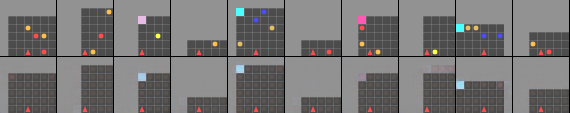

In [40]:
from PIL import Image
def visualize_reconstruction(model, ds, count=10):

    data_loader = DataLoader(ds, batch_size=10)
    xs = next(iter(data_loader))[0]

    # get reconstructions
    preds = torch.sigmoid(model.forward(xs.to(device))[0]).cpu()

    # concatenate all data
    x_cat = torch.cat([torch.cat([x, torch.zeros(3,56, 1)], dim=-1) for x in xs], dim=-1)
    pred_cat = torch.cat([torch.cat([x, torch.zeros(3,56, 1)], dim=-1) for x in preds], dim=-1)
    
    to_image = transforms.Compose([
        # inverts normalisation of image # TODO? implement unnormalize
        # transforms.Normalize(-means / stds, 1. / stds), 
        transforms.Lambda(lambda x: torch.clamp(x, 0, 1)),
        transforms.ToPILImage()
    ])
    
    x_im = to_image(x_cat)
    res_im = to_image(pred_cat)

    # paste together
    im = Image.new('RGB', (len(xs) * 57, 56*2+1))
    im.paste(x_im, (0, 0))
    im.paste(res_im, (0, 57))
    display(im, metadata={'width': '100%'})

visualize_reconstruction(model, ds)

In [41]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [42]:
import numpy as np
import time
from datetime import datetime

In [43]:
losses = []
batch_size=128
data_loader = DataLoader(ds, batch_size=batch_size)
bce = nn.BCEWithLogitsLoss(reduction='sum')
optim_a = optim.Adam(model.parameters(),lr=1e-4)

In [44]:
epochs = 100
plt_every = 5
save_every = 20
save_path="./checkpoints/"
kl_weight = 1 #1e-5

for epoch in range(epochs):
    epoch_loss = []
    with tqdm(data_loader, unit="batch") as tepoch:
        tepoch.set_description("epoch "+str(epoch)+"/"+str(epochs))
        for x_true, label in tepoch:
            x_true = x_true.to(device)
            
            y, (mu, log_var) = model.forward(x_true)
            reg_loss = kl_weight * gauss_vae_regulariser(mu, log_var)
            recon_loss = bce(y, x_true).div(batch_size)

            epoch_loss.append([recon_loss.detach().cpu().numpy(), reg_loss.detach().cpu().numpy()])

            loss = recon_loss + reg_loss

            optim_a.zero_grad()
            loss.backward(retain_graph=False)
            optim_a.step()

            # losses.append(loss.detach().cpu().numpy())
        # end of epoch
        epoch_loss = np.array(epoch_loss)
        l1, l2 = epoch_loss[:,0].sum(), epoch_loss[:,1].sum()
        
        losses.append(l1+l2)
        if epoch % plt_every == 0:
            plt.plot(losses)
            plt.show()
            visualize_reconstruction(model, ds)

        # tepoch.set_postfix(reconstruction_loss=l1, kl_loss=l2)
        print("reconstruction loss", l1, "kl loss", l2)
        if epoch % save_every == 0:
            name = save_path + "vae_" +datetime.now().strftime("%Y-%m-%d_%H-%M-%S")+"_"+str(l1+l2)+".save"
            torch.save(model.state_dict(), name)
            print("model saved as", name)


plt.plot(losses)
plt.show()

epoch 0/100:   5%|▌         | 4/79 [00:00<00:04, 17.30batch/s]torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
epoch 0/100:   8%|▊         | 6/79 [00:00<00:04, 17.32batch/s]torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
epoch 0/100:  15%|█▌        | 12/79 [00:00<00:03, 17.30batch/s]torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
epoch 0/100:  20%|██        | 16/79 [00:00<00:03, 17.34batch/s]torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
epoch 0/100:  23%|██▎       | 18/79 [00:01<00:03, 16.95batch/s]torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
epoch 0/100:  30%|███       | 24/79 [00:01<00:03, 17.20batch/s]torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
epoch 0/100:  35%|███▌      | 28/79 [00:01<00:02, 17.23batch/s]torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
epoch 0/100:  41%|████      | 32/79 [00:01<00:02, 16.88ba

KeyboardInterrupt: 

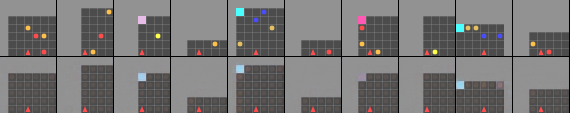

In [37]:
visualize_reconstruction(model, ds)